In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config import config
from finrl.marketdata.local_data import *
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.model.models import DRLAgent
from finrl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/opt/conda/lib/python3.6/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [2]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [3]:
# Download and save the data in a pandas DataFrame:
files = [
    './data/1332.csv'
]
df = LocalQuery(start_date = '2014-08-25',
                          end_date = '2019-08-23',
                          files = files).fetch_data()

Shape of DataFrame:  (1222, 8)


In [4]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=True,
                    user_defined_feature = False)
processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [5]:
config.TECHNICAL_INDICATORS_LIST

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [6]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [7]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

date   tic   open   high    low  close     volume  day      macd  \
0  2014-08-25  1332  302.0  307.0  298.0  304.0  4222900.0  0.0  0.000000   
1  2014-08-26  1332  307.0  308.0  303.0  308.0  2252200.0  1.0  0.089744   
2  2014-08-27  1332  307.0  309.0  302.0  306.0  2351000.0  2.0  0.052331   
3  2014-08-28  1332  304.0  308.0  303.0  305.0  1367800.0  3.0 -0.002072   
4  2014-08-29  1332  302.0  306.0  300.0  302.0  1631600.0  4.0 -0.150967   
5  2014-09-01  1332  302.0  307.0  302.0  303.0  1404800.0  0.0 -0.194875   
6  2014-09-02  1332  304.0  308.0  304.0  306.0  1415200.0  1.0 -0.083771   
7  2014-09-03  1332  307.0  308.0  304.0  305.0  1360300.0  2.0 -0.055486   
8  2014-09-04  1332  304.0  307.0  301.0  302.0  1185700.0  3.0 -0.183896   
9  2014-09-05  1332  305.0  305.0  301.0  302.0  1626500.0  4.0 -0.272311   

      boll_ub     boll_lb      rsi_30     cci_30       dx_30  close_30_sma  \
0  311.656854  300.343146  100.000000  66.666667  100.000000    304.000000   
1  311.656854  300.343146  100.000000  66.666667  100.000000    306.000000   
2  310.000000  302.000000   65.909091  33.333333  100.000000    306.000000   
3  309.165650  302.334350   56.029314  16.000000  100.000000    305.750000   
4  309.472136  300.527864   38.239860 -91.194969   57.122765    305.000000   
5  308.987160  300.346173   44.334340 -26.086957   22.758743    304.666667   
6  308.927945  300.786341   57.385068  67.021277    0.502840    304.857143   
7  308.645184  301.104816   53.092816  45.977011    0.502840    304.875000   
8  308.569420  300.541691   43.090282 -70.588235   39.073836    304.555556   
9  308.415013  300.184987   43.090282 -90.000000   39.073836    304.300000   

   close_60_sma  turbulence  
0    304.000000         0.0  
1    306.000000         0.0  
2    306.000000         0.0  
3    305.750000         0.0  
4    305.000000         0.0  
5    304.666667         0.0  
6    304.857143         0.0  
7    304.875000         0.0  
8    304.555556         0.0  
9    304.300000         0.0

In [8]:
train = data_split(processed_full, '2014-08-25','2018-12-31')
trade = data_split(processed_full, '2019-01-01','2019-08-23')
print(len(train))
print(len(trade))

1067
154


In [9]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 11


In [10]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 10000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [11]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [12]:
agent = DRLAgent(env = env_train)

In [13]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [14]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=100000)

Logging to tensorboard_log/a2c/a2c_14
------------------------------------
| time/                 |          |
|    fps                | 218      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.43    |
|    explained_variance | -4.29    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.0757  |
|    std                | 1.02     |
|    value_loss         | 0.00482  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 243      |
|    iterations         | 200      |
|    time_elapsed       | 4        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -1.46    |
|    explained_variance | -62.5    |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |


------------------------------------
| time/                 |          |
|    fps                | 245      |
|    iterations         | 1400     |
|    time_elapsed       | 28       |
|    total_timesteps    | 7000     |
| train/                |          |
|    entropy_loss       | -1.69    |
|    explained_variance | 0.693    |
|    learning_rate      | 0.0007   |
|    n_updates          | 1399     |
|    policy_loss        | -0.0099  |
|    std                | 1.31     |
|    value_loss         | 0.000361 |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.7e+04  |
|    total_cost         | 1.58e+03 |
|    total_reward       | 7.01e+03 |
|    total_reward_pct   | 70.1     |
|    total_trades       | 1024     |
| time/                 |          |
|    fps                | 246      |
|    iterations         | 1500     |
|    time_elapsed       | 30       |
|    total_timesteps    | 7500     |
|

------------------------------------
| time/                 |          |
|    fps                | 246      |
|    iterations         | 2700     |
|    time_elapsed       | 54       |
|    total_timesteps    | 13500    |
| train/                |          |
|    entropy_loss       | -1.99    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 2699     |
|    policy_loss        | -0.0183  |
|    std                | 1.77     |
|    value_loss         | 0.000282 |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 9.07e+03 |
|    total_cost         | 1.19e+03 |
|    total_reward       | -931     |
|    total_reward_pct   | -9.31    |
|    total_trades       | 914      |
| time/                 |          |
|    fps                | 245      |
|    iterations         | 2800     |
|    time_elapsed       | 56       |
|    total_timesteps    | 14000    |
|

------------------------------------
| time/                 |          |
|    fps                | 245      |
|    iterations         | 4000     |
|    time_elapsed       | 81       |
|    total_timesteps    | 20000    |
| train/                |          |
|    entropy_loss       | -2.29    |
|    explained_variance | -6.34    |
|    learning_rate      | 0.0007   |
|    n_updates          | 3999     |
|    policy_loss        | -0.0849  |
|    std                | 2.39     |
|    value_loss         | 0.00135  |
------------------------------------
day: 1066, episode: 20
begin_total_asset: 10000.00
end_total_asset: 11060.93
total_reward: 1060.93
total_cost: 1086.08
total_trades: 1021
Sharpe: 0.298
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.11e+04 |
|    total_cost         | 1.09e+03 |
|    total_reward       | 1.06e+03 |
|    total_reward_pct   | 10.6     |
|    total_trades       | 1021     |
| time/                 |         

-------------------------------------
| time/                 |           |
|    fps                | 245       |
|    iterations         | 5300      |
|    time_elapsed       | 108       |
|    total_timesteps    | 26500     |
| train/                |           |
|    entropy_loss       | -2.63     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 5299      |
|    policy_loss        | 0.0191    |
|    std                | 3.35      |
|    value_loss         | 0.000128  |
-------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 7.54e+03  |
|    total_cost         | 543       |
|    total_reward       | -2.46e+03 |
|    total_reward_pct   | -24.6     |
|    total_trades       | 1044      |
| time/                 |           |
|    fps                | 245       |
|    iterations         | 5400      |
|    time_elapsed       | 110       |
|    total_t

-------------------------------------
| time/                 |           |
|    fps                | 245       |
|    iterations         | 6600      |
|    time_elapsed       | 134       |
|    total_timesteps    | 33000     |
| train/                |           |
|    entropy_loss       | -2.94     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 6599      |
|    policy_loss        | -0.000181 |
|    std                | 4.56      |
|    value_loss         | 6.18e-09  |
-------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 2.24e+04 |
|    total_cost         | 1.18e+03 |
|    total_reward       | 1.24e+04 |
|    total_reward_pct   | 124      |
|    total_trades       | 969      |
| time/                 |          |
|    fps                | 245      |
|    iterations         | 6700     |
|    time_elapsed       | 136      |
|    total_timesteps   

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.09e+04 |
|    total_cost         | 2.98e+03 |
|    total_reward       | 1.09e+04 |
|    total_reward_pct   | 109      |
|    total_trades       | 954      |
| time/                 |          |
|    fps                | 245      |
|    iterations         | 7900     |
|    time_elapsed       | 160      |
|    total_timesteps    | 39500    |
| train/                |          |
|    entropy_loss       | -3.27    |
|    explained_variance | 0.463    |
|    learning_rate      | 0.0007   |
|    n_updates          | 7899     |
|    policy_loss        | -0.0199  |
|    std                | 6.36     |
|    value_loss         | 8.2e-05  |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 245       |
|    iterations         | 8000      |
|    time_elapsed       | 162       |
|    total_timesteps    | 40000  

------------------------------------
| time/                 |          |
|    fps                | 245      |
|    iterations         | 9100     |
|    time_elapsed       | 185      |
|    total_timesteps    | 45500    |
| train/                |          |
|    entropy_loss       | -3.58    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 9099     |
|    policy_loss        | 0.413    |
|    std                | 8.66     |
|    value_loss         | 0.0157   |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.38e+04 |
|    total_cost         | 1.67e+03 |
|    total_reward       | 3.83e+03 |
|    total_reward_pct   | 38.3     |
|    total_trades       | 1027     |
| time/                 |          |
|    fps                | 245      |
|    iterations         | 9200     |
|    time_elapsed       | 187      |
|    total_timesteps    | 46000    |
|

------------------------------------
| time/                 |          |
|    fps                | 246      |
|    iterations         | 10400    |
|    time_elapsed       | 211      |
|    total_timesteps    | 52000    |
| train/                |          |
|    entropy_loss       | -3.95    |
|    explained_variance | 0.345    |
|    learning_rate      | 0.0007   |
|    n_updates          | 10399    |
|    policy_loss        | -0.00127 |
|    std                | 12.6     |
|    value_loss         | 2.29e-06 |
------------------------------------
day: 1066, episode: 50
begin_total_asset: 10000.00
end_total_asset: 6166.49
total_reward: -3833.51
total_cost: 1302.51
total_trades: 920
Sharpe: -0.070
-------------------------------------
| environment/          |           |
|    portfolio_value    | 6.17e+03  |
|    total_cost         | 1.3e+03   |
|    total_reward       | -3.83e+03 |
|    total_reward_pct   | -38.3     |
|    total_trades       | 920       |
| time/                 |  

------------------------------------
| time/                 |          |
|    fps                | 245      |
|    iterations         | 11700    |
|    time_elapsed       | 237      |
|    total_timesteps    | 58500    |
| train/                |          |
|    entropy_loss       | -4.38    |
|    explained_variance | -0.303   |
|    learning_rate      | 0.0007   |
|    n_updates          | 11699    |
|    policy_loss        | 0.0908   |
|    std                | 19.4     |
|    value_loss         | 0.00051  |
------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 7.62e+03  |
|    total_cost         | 2.16e+03  |
|    total_reward       | -2.38e+03 |
|    total_reward_pct   | -23.8     |
|    total_trades       | 917       |
| time/                 |           |
|    fps                | 245       |
|    iterations         | 11800     |
|    time_elapsed       | 239       |
|    total_timesteps    | 5

------------------------------------
| time/                 |          |
|    fps                | 246      |
|    iterations         | 13000    |
|    time_elapsed       | 263      |
|    total_timesteps    | 65000    |
| train/                |          |
|    entropy_loss       | -4.74    |
|    explained_variance | -0.797   |
|    learning_rate      | 0.0007   |
|    n_updates          | 12999    |
|    policy_loss        | -0.0117  |
|    std                | 27.7     |
|    value_loss         | 0.000181 |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.97e+04 |
|    total_cost         | 6.35e+03 |
|    total_reward       | 9.71e+03 |
|    total_reward_pct   | 97.1     |
|    total_trades       | 826      |
| time/                 |          |
|    fps                | 246      |
|    iterations         | 13100    |
|    time_elapsed       | 265      |
|    total_timesteps    | 65500    |
|

-------------------------------------
| environment/          |           |
|    portfolio_value    | 8.97e+03  |
|    total_cost         | 3.53e+03  |
|    total_reward       | -1.03e+03 |
|    total_reward_pct   | -10.3     |
|    total_trades       | 832       |
| time/                 |           |
|    fps                | 246       |
|    iterations         | 14300     |
|    time_elapsed       | 290       |
|    total_timesteps    | 71500     |
| train/                |           |
|    entropy_loss       | -5.16     |
|    explained_variance | -0.0238   |
|    learning_rate      | 0.0007    |
|    n_updates          | 14299     |
|    policy_loss        | -0.0342   |
|    std                | 42        |
|    value_loss         | 9.3e-05   |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 246      |
|    iterations         | 14400    |
|    time_elapsed       | 292      |
|    total_timest

------------------------------------
| time/                 |          |
|    fps                | 246      |
|    iterations         | 15500    |
|    time_elapsed       | 314      |
|    total_timesteps    | 77500    |
| train/                |          |
|    entropy_loss       | -5.55    |
|    explained_variance | -0.347   |
|    learning_rate      | 0.0007   |
|    n_updates          | 15499    |
|    policy_loss        | 0.0343   |
|    std                | 62.2     |
|    value_loss         | 4.79e-05 |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.06e+04 |
|    total_cost         | 3.72e+03 |
|    total_reward       | 647      |
|    total_reward_pct   | 6.47     |
|    total_trades       | 825      |
| time/                 |          |
|    fps                | 246      |
|    iterations         | 15600    |
|    time_elapsed       | 316      |
|    total_timesteps    | 78000    |
|

------------------------------------
| time/                 |          |
|    fps                | 246      |
|    iterations         | 16800    |
|    time_elapsed       | 340      |
|    total_timesteps    | 84000    |
| train/                |          |
|    entropy_loss       | -6.04    |
|    explained_variance | -25.4    |
|    learning_rate      | 0.0007   |
|    n_updates          | 16799    |
|    policy_loss        | 0.01     |
|    std                | 102      |
|    value_loss         | 0.000104 |
------------------------------------
day: 1066, episode: 80
begin_total_asset: 10000.00
end_total_asset: 3153.66
total_reward: -6846.34
total_cost: 1714.34
total_trades: 779
Sharpe: -0.570
-------------------------------------
| environment/          |           |
|    portfolio_value    | 3.15e+03  |
|    total_cost         | 1.71e+03  |
|    total_reward       | -6.85e+03 |
|    total_reward_pct   | -68.5     |
|    total_trades       | 779       |
| time/                 |  

------------------------------------
| time/                 |          |
|    fps                | 246      |
|    iterations         | 18100    |
|    time_elapsed       | 366      |
|    total_timesteps    | 90500    |
| train/                |          |
|    entropy_loss       | -6.57    |
|    explained_variance | -3.84    |
|    learning_rate      | 0.0007   |
|    n_updates          | 18099    |
|    policy_loss        | 0.103    |
|    std                | 172      |
|    value_loss         | 0.000351 |
------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 7.55e+03  |
|    total_cost         | 4.32e+03  |
|    total_reward       | -2.45e+03 |
|    total_reward_pct   | -24.5     |
|    total_trades       | 795       |
| time/                 |           |
|    fps                | 246       |
|    iterations         | 18200     |
|    time_elapsed       | 368       |
|    total_timesteps    | 9

------------------------------------
| time/                 |          |
|    fps                | 246      |
|    iterations         | 19400    |
|    time_elapsed       | 393      |
|    total_timesteps    | 97000    |
| train/                |          |
|    entropy_loss       | -7.04    |
|    explained_variance | -2.42    |
|    learning_rate      | 0.0007   |
|    n_updates          | 19399    |
|    policy_loss        | -0.0512  |
|    std                | 276      |
|    value_loss         | 7.12e-05 |
------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 4.37e+03  |
|    total_cost         | 2.69e+03  |
|    total_reward       | -5.63e+03 |
|    total_reward_pct   | -56.3     |
|    total_trades       | 802       |
| time/                 |           |
|    fps                | 246       |
|    iterations         | 19500     |
|    time_elapsed       | 395       |
|    total_timesteps    | 9

In [15]:
data_turbulence = processed_full[(processed_full.date<'2018-12-31') & (processed_full.date>='2014-08-25')]
insample_turbulence = data_turbulence.drop_duplicates(subset=['date'])

In [16]:
insample_turbulence.turbulence.describe()

count    1067.000000
mean        0.676717
std         2.341909
min         0.000000
25%         0.000145
50%         0.079961
75%         0.501794
max        46.564480
Name: turbulence, dtype: float64

In [17]:
turbulence_threshold = np.quantile(insample_turbulence.turbulence.values,1)

In [18]:
turbulence_threshold

46.564479738758294

In [19]:
trade = data_split(processed_full, '2019-01-01','2019-08-23')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 50, **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [20]:
trade

date   tic   open   high    low  close     volume  day       macd  \
0    2019-01-04  1332  598.0  615.0  595.0  615.0  2188000.0  4.0 -23.289664   
1    2019-01-07  1332  625.0  632.0  621.0  623.0  1751500.0  0.0 -22.236393   
2    2019-01-08  1332  628.0  635.0  624.0  633.0  2184800.0  1.0 -20.360054   
3    2019-01-09  1332  643.0  655.0  640.0  647.0  3532800.0  2.0 -17.541155   
4    2019-01-10  1332  648.0  655.0  640.0  651.0  2512500.0  3.0 -14.813629   
..          ...   ...    ...    ...    ...    ...        ...  ...        ...   
149  2019-08-16  1332  586.0  592.0  583.0  588.0  1131100.0  4.0 -26.091964   
150  2019-08-19  1332  598.0  601.0  591.0  597.0  1221800.0  0.0 -26.219439   
151  2019-08-20  1332  600.0  608.0  595.0  601.0  1691100.0  1.0 -25.701427   
152  2019-08-21  1332  599.0  605.0  597.0  602.0  1599100.0  2.0 -24.922911   
153  2019-08-22  1332  603.0  616.0  602.0  610.0  2884000.0  3.0 -23.390764   

        boll_ub     boll_lb     rsi_30      cci_30      dx_30  close_30_sma  \
0    720.547964  587.452036  39.763475 -140.651885  49.252371    671.066667   
1    716.983119  584.716881  41.571829  -93.747039  31.972314    668.300000   
2    712.628173  583.771827  43.755257  -75.228932  29.151596    665.800000   
3    706.565991  585.134009  46.643004  -36.633895  12.079886    663.666667   
4    702.091077  586.208923  47.440600  -30.447306  12.079886    662.000000   
..          ...         ...        ...         ...        ...           ...   
149  749.213755  564.486245  37.115389 -151.168220  56.323894    670.500000   
150  743.513755  558.786245  38.800659 -120.340909  46.746563    667.000000   
151  738.823283  553.976717  39.545553 -101.133721  39.633947    663.833333   
152  732.335884  550.664116  39.735256  -92.284652  39.633947    661.200000   
153  725.081253  549.218747  41.260671  -73.820089  28.454205    658.533333   

     close_60_sma  turbulence  
0      693.500000    0.012011  
1      691.916667    0.833709  
2      690.583333    1.264870  
3      689.666667    2.384480  
4      688.433333    0.168991  
..            ...         ...  
149    668.100000    0.000578  
150    666.483333    0.666322  
151    665.083333    0.114941  
152    664.000000    0.005083  
153    663.250000    0.527316  

[154 rows x 17 columns]

In [21]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym)

hit end!


In [22]:
df_account_value

date  account_value
0    2019-01-04      10000.000
1    2019-01-07      10000.000
2    2019-01-08      10000.000
3    2019-01-09      10000.000
4    2019-01-10      10000.000
..          ...            ...
149  2019-08-16       8677.915
150  2019-08-19       8677.915
151  2019-08-20       8677.915
152  2019-08-21       8683.501
153  2019-08-22       8795.501

[154 rows x 2 columns]

In [23]:
df_actions

date actions
0    2019-01-04     [0]
1    2019-01-07     [0]
2    2019-01-08     [0]
3    2019-01-09     [0]
4    2019-01-10    [15]
..          ...     ...
148  2019-08-15   [-14]
149  2019-08-16     [0]
150  2019-08-19     [0]
151  2019-08-20    [14]
152  2019-08-21     [0]

[153 rows x 2 columns]

In [24]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return         -0.189431
Cumulative returns    -0.120450
Annual volatility      0.197085
Sharpe ratio          -0.973801
Calmar ratio          -1.122119
Stability              0.461506
Max drawdown          -0.168815
Omega ratio            0.796868
Sortino ratio         -1.286461
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.850696
Daily value at risk   -0.025592
dtype: float64


In [25]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="./data/1332.csv", 
        start = '2019-01-01',
        end = '2019-08-23')
print(baseline_df)
stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
Shape of DataFrame:  (1222, 8)
           date   open   high    low  close   volume   tic  day
0    2019-01-04  598.0  615.0  595.0  615.0  2188000  1332    4
1    2019-01-07  625.0  632.0  621.0  623.0  1751500  1332    0
2    2019-01-08  628.0  635.0  624.0  633.0  2184800  1332    1
3    2019-01-09  643.0  655.0  640.0  647.0  3532800  1332    2
4    2019-01-10  648.0  655.0  640.0  651.0  2512500  1332    3
..          ...    ...    ...    ...    ...      ...   ...  ...
149  2019-08-16  586.0  592.0  583.0  588.0  1131100  1332    4
150  2019-08-19  598.0  601.0  591.0  597.0  1221800  1332    0
151  2019-08-20  600.0  608.0  595.0  601.0  1691100  1332    1
152  2019-08-21  599.0  605.0  597.0  602.0  1599100  1332    2
153  2019-08-22  603.0  616.0  602.0  610.0  2884000  1332    3

[154 rows x 8 columns]
Annual return         -0.013269
Cumulative returns    -0.008130
Annual volatility      0.300279
Sharpe ratio           0.104481
Calma

==============Compare to DJIA===========
Shape of DataFrame:  (1222, 8)


/opt/conda/lib/python3.6/site-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


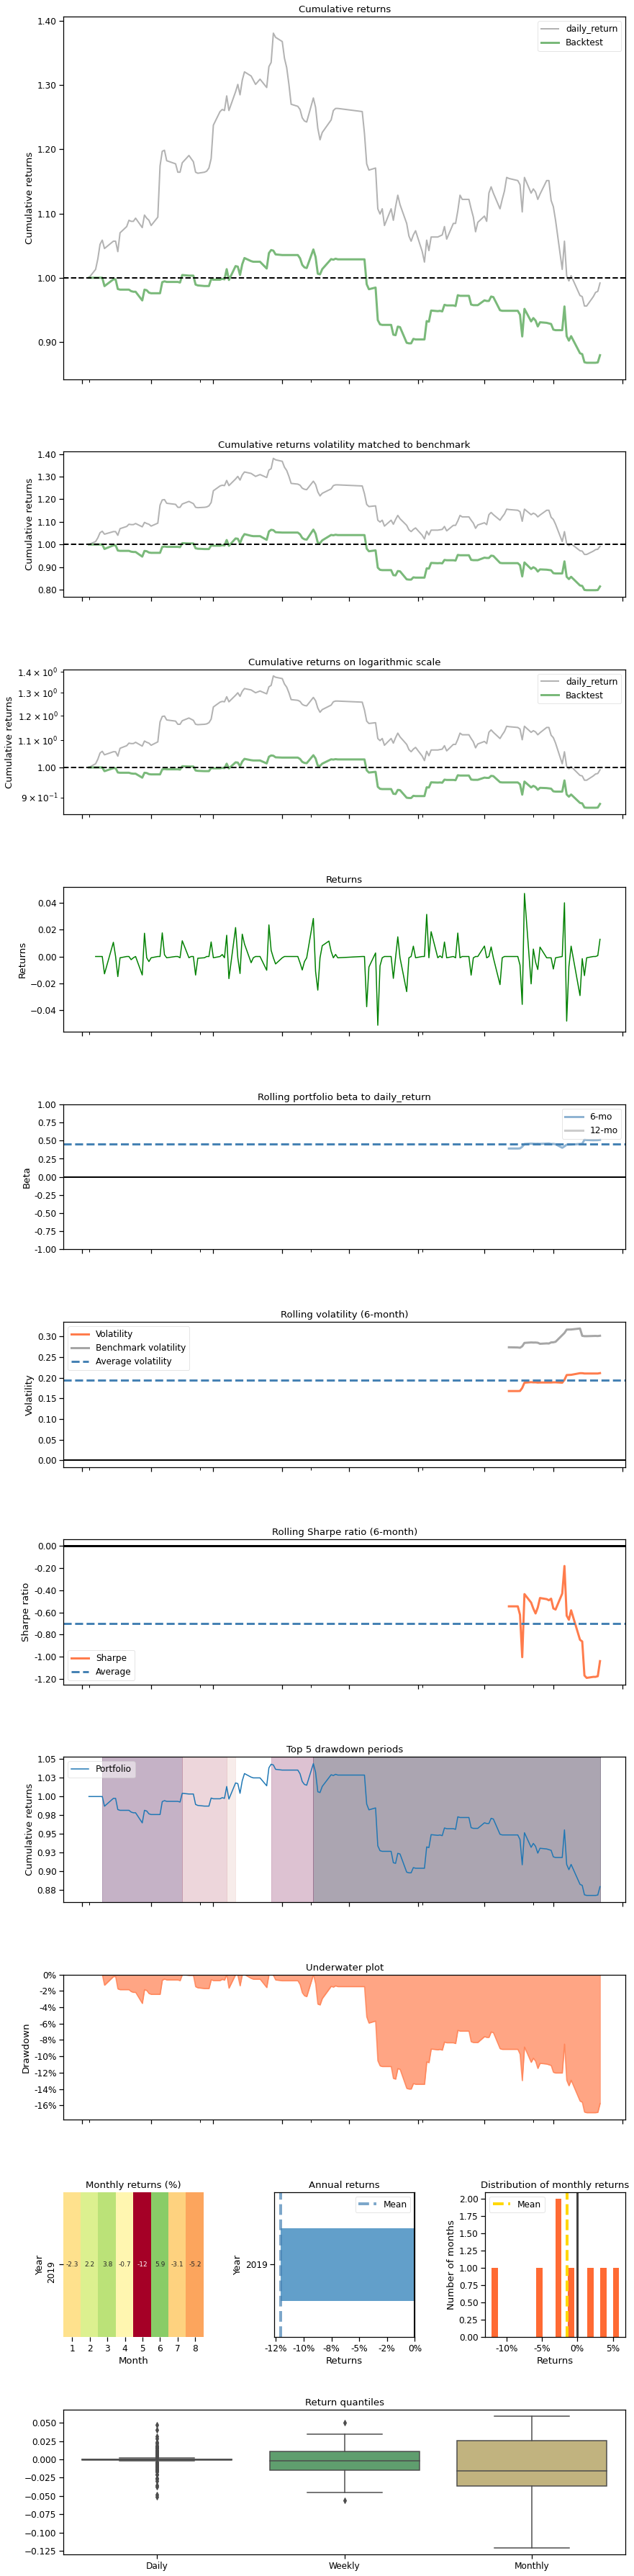

In [26]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = "./data/1332.csv", 
             baseline_start = '2019-01-01',
             baseline_end = '2019-08-23')

In [27]:
from finrl.trade.backtest import *

In [28]:
get_daily_return(baseline_df, value_col_name='close')

date
2019-01-04 00:00:00+00:00         NaN
2019-01-07 00:00:00+00:00    0.013008
2019-01-08 00:00:00+00:00    0.016051
2019-01-09 00:00:00+00:00    0.022117
2019-01-10 00:00:00+00:00    0.006182
                               ...   
2019-08-16 00:00:00+00:00    0.000000
2019-08-19 00:00:00+00:00    0.015306
2019-08-20 00:00:00+00:00    0.006700
2019-08-21 00:00:00+00:00    0.001664
2019-08-22 00:00:00+00:00    0.013289
Name: daily_return, Length: 154, dtype: float64

In [29]:
baseline_df

date   open   high    low  close   volume   tic  day
0    2019-01-04  598.0  615.0  595.0  615.0  2188000  1332    4
1    2019-01-07  625.0  632.0  621.0  623.0  1751500  1332    0
2    2019-01-08  628.0  635.0  624.0  633.0  2184800  1332    1
3    2019-01-09  643.0  655.0  640.0  647.0  3532800  1332    2
4    2019-01-10  648.0  655.0  640.0  651.0  2512500  1332    3
..          ...    ...    ...    ...    ...      ...   ...  ...
149  2019-08-16  586.0  592.0  583.0  588.0  1131100  1332    4
150  2019-08-19  598.0  601.0  591.0  597.0  1221800  1332    0
151  2019-08-20  600.0  608.0  595.0  601.0  1691100  1332    1
152  2019-08-21  599.0  605.0  597.0  602.0  1599100  1332    2
153  2019-08-22  603.0  616.0  602.0  610.0  2884000  1332    3

[154 rows x 8 columns]